# projectGoal

we got a problem chat<br>
when shooting from close zone/center of field our auto aim works pretty damn well<br>
when shooting from far zone the angle makes the opposite side shooter miss almost all the time<br>
its because PID loop just pointing at the AprilTag, not at the actual goal<br>
also were doing *fIzZiX* 🧙 to do driveby shots and trickshots and we need this for that so might as well

currently ts camera returns range, bearing, and yaw of how it sees the apriltag on the goal<br>
problem is were tryna score the ball not shoot it at a glorified qr code<br>
the objective here is to do some trig to create a method that takes how the camera sees the apriltag and translate the start pos from camera to the shooter and the end pos from the apriltag to the goal<br>
were gonna need range, bearing, elevation, and **yaw** cuz the apriltag angle affects ts end offset, not the camera angle<br>
were gonna do the math in Python and then port it to Java like a real one<br>

first step is converting ts deg to rad cuz numpy like that<br>
second step is turn ts into XYZ translation

In [79]:
import numpy as np

def projectGoal(rDist, bDeg, eDeg, yDeg):
    initBRad = np.radians(bDeg)
    initERad = np.radians(eDeg)
    initYRad = np.radians(yDeg)

    initXYDist = rDist * np.cos(initERad)
    initZDist = rDist * np.sin(initERad)
    initXDist = initXYDist * np.sin(initBRad)
    initYDist = initXYDist * np.cos(initBRad)

    print(initXDist)
    print(initYDist)
    print(initZDist)

In [80]:
projectGoal(67, 67, 67, 67)

24.097883311344813
10.22894458962359
61.673825181313504


In [81]:
print((24.097883311344813 ** 2 + 10.22894458962359 ** 2 + 61.673825181313504 ** 2) ** 0.5)

67.0


W ts works now js convert the extake and goal offsets into XYZ translations also<br>
lets just make all that range bearing deg to XYZ a function<br>
and lets also make an inverse of that function cuz itll come in handy ltr

In [82]:
import numpy as np

def traceXYZ(rDist, bRad, eRad):
    distXY = rDist * np.cos(eRad)
    distZ = rDist * np.sin(eRad)
    distX = distXY * np.sin(bRad)
    distY = distXY * np.cos(bRad)

    return distX, distY, distZ

def traceRBE(x, y, z):
    rDist = np.sqrt(x*x + y*y + z*z)
    eRad = np.arctan2(z, np.sqrt(x*x + y*y))
    bRad = np.arctan2(x, y)

    return rDist, bRad, eRad

In [83]:
xyz = traceXYZ(67, np.radians(67), np.radians(67))
print(xyz)
print(traceRBE(*xyz))

(np.float64(24.097883311344813), np.float64(10.22894458962359), np.float64(61.673825181313504))
(np.float64(67.0), np.float64(1.1693705988362009), np.float64(1.1693705988362009))


W ok so the maths are mathing now lets bring ts all together<br>
we take in an AprilTagDetection range bearing elevation and yaw, convert it to XYZ. get the constant goal offset, convert to RBE, rotate by yaw, convert it back to XYZ. add both translations and convert back to RBE.

In [84]:
import numpy as np
import plotly.graph_objects as go

GOAL_OFFSET = (0.740128657074, 12.9696232669, 9.25) # BLUE GOAL relative to AprilTag

def projectGoal(rDist, bDeg, eDeg, yDeg):
    initXYZ = traceXYZ(rDist, np.radians(-bDeg), np.radians(eDeg))
    goalRBE = list(traceRBE(*GOAL_OFFSET)) # real XYZ offsets that will be used in prod, RBE should be precomputed or at least on init
    goalRBE[1] += np.radians(-yDeg)
    goalXYZ = traceXYZ(*goalRBE)
    finalXYZ = [sum(i) for i in zip(initXYZ, goalXYZ)]
    finalRBE = traceRBE(*finalXYZ)

    # visualization
    fig = go.Figure()

    def draw_trace(start, vector, name, color):
        end = [s + v for s, v in zip(start, vector)]
        x, y, z = start
        dx, dy, dz = vector
        
        fig.add_trace(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=5)
        ))
        
        fig.add_trace(go.Scatter3d(
            x=[x, x+dx, x+dx, x+dx],
            y=[y, y, y+dy, y+dy],
            z=[z, z, z, z+dz],
            mode="lines",
            name=f"{name} XYZ",
            line=dict(color=color, width=2, dash="dash")
        ))
    
    draw_trace([0, 0, 0], initXYZ, "camera -> apriltag", "blue")
    draw_trace(initXYZ, goalXYZ, "apriltag -> goal", "red")
    draw_trace([0, 0, 0], finalXYZ, "camera -> goal", "green")

    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data"
        ),
        title="ts projection"
    )
    
    fig.show()

    return finalRBE

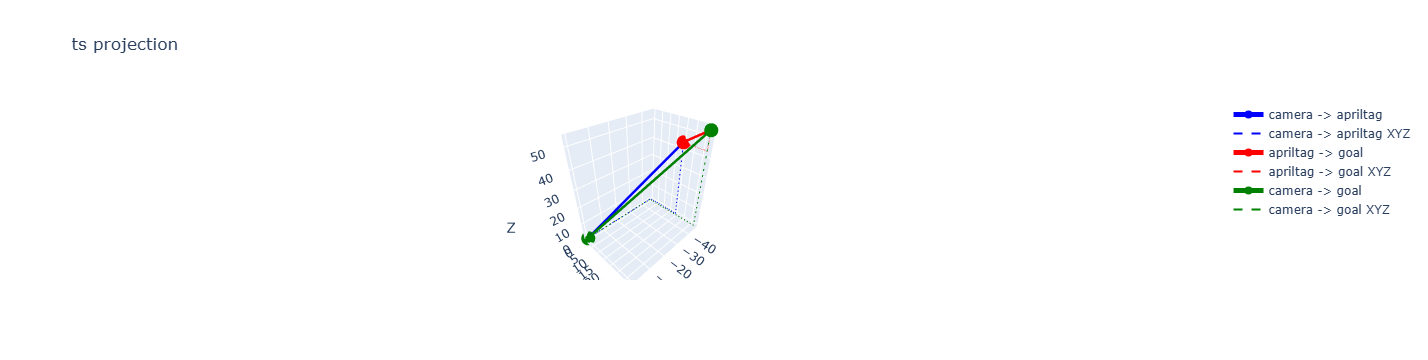

(np.float64(77.46032699280487), np.float64(-0.9504196585723249), np.float64(0.7571874307996309))


In [85]:
print(projectGoal(67, 67, 41, 0))

alr W<br>
the math is mathing and the graphs are graphing<br>
now just need to add the shooter offset

In [86]:
import numpy as np
import plotly.graph_objects as go

GOAL_OFFSET = (0.740128657074, 12.9696232669, 9.25) # BLUE GOAL relative to AprilTag
EXTAKE_OFFSET = (0.0, 2.0, -5.0) # EXTAKE relative to CAMERA

def projectGoal(rDist, bDeg, eDeg, yDeg):
    initXYZ = traceXYZ(rDist, np.radians(-bDeg), np.radians(eDeg))
    goalRBE = list(traceRBE(*GOAL_OFFSET)) # real XYZ offsets that will be used in prod, RBE should be precomputed or at least on init
    goalRBE[1] += np.radians(-yDeg)
    goalXYZ = traceXYZ(*goalRBE)
    finalXYZ = [sum(i) for i in zip(initXYZ, goalXYZ, [-i for i in EXTAKE_OFFSET])]
    finalRBE = traceRBE(*finalXYZ)

    # visualization
    fig = go.Figure()

    def draw_trace(start, vector, name, color):
        end = [s + v for s, v in zip(start, vector)]
        x, y, z = start
        dx, dy, dz = vector
        
        fig.add_trace(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=5)
        ))
        
        fig.add_trace(go.Scatter3d(
            x=[x, x+dx, x+dx, x+dx],
            y=[y, y, y+dy, y+dy],
            z=[z, z, z, z+dz],
            mode="lines",
            name=f"{name} XYZ",
            line=dict(color=color, width=2, dash="dash")
        ))

    draw_trace([0, 0, 0], initXYZ, "camera -> apriltag", "blue")
    draw_trace(initXYZ, goalXYZ, "apriltag -> goal", "red")
    draw_trace(EXTAKE_OFFSET, [-i for i in EXTAKE_OFFSET], "extake -> camera", "yellow")
    draw_trace(EXTAKE_OFFSET, finalXYZ, "extake -> goal", "green")

    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data"
        ),
        title="ts projection"
    )
    
    fig.show()

    return finalRBE

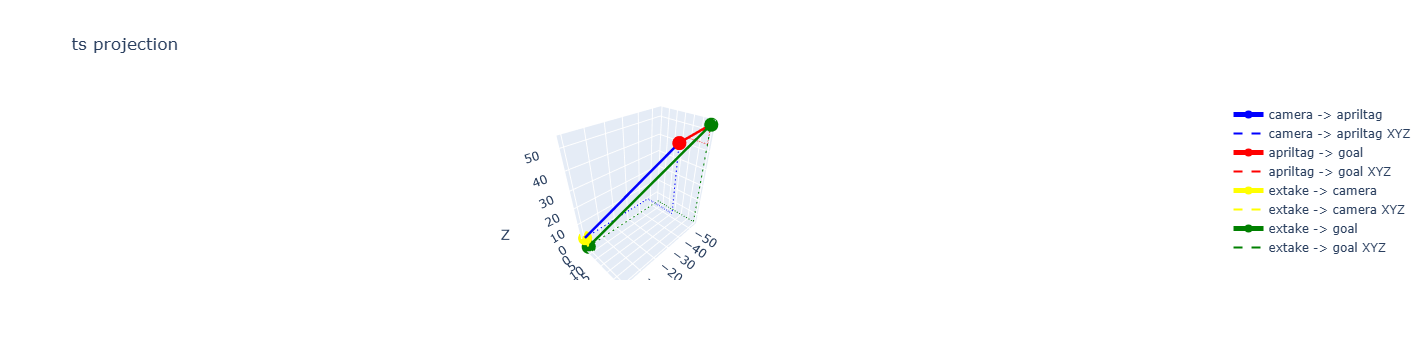

(np.float64(84.51932050368912), np.float64(-1.0957153173710668), np.float64(0.7596537206726418))


In [87]:
print(projectGoal(67, 67, 41, 41))

without visualization:

In [88]:
import numpy as np

GOAL_OFFSET = (0.740128657074, 12.9696232669, 9.25) # BLUE GOAL relative to AprilTag
EXTAKE_OFFSET = (0.0, 2.0, -5.0) # EXTAKE relative to CAMERA

def traceXYZ(rDist, bRad, eRad):
    distXY = rDist * np.cos(eRad)
    distZ = rDist * np.sin(eRad)
    distX = distXY * np.sin(bRad)
    distY = distXY * np.cos(bRad)

    return distX, distY, distZ

def traceRBE(x, y, z):
    rDist = np.sqrt(x*x + y*y + z*z)
    eRad = np.arctan2(z, np.sqrt(x*x + y*y))
    bRad = np.arctan2(x, y)

    return rDist, bRad, eRad

def projectGoal(rDist, bDeg, eDeg, yDeg):
    initXYZ = traceXYZ(rDist, np.radians(-bDeg), np.radians(eDeg))
    goalRBE = list(traceRBE(*GOAL_OFFSET)) # real XYZ offsets that will be used in prod, RBE should be precomputed or at least on init
    goalRBE[1] += np.radians(-yDeg)
    goalXYZ = traceXYZ(*goalRBE)
    finalXYZ = [sum(i) for i in zip(initXYZ, goalXYZ, [-i for i in EXTAKE_OFFSET])]
    finalRBE = traceRBE(*finalXYZ)

    return finalRBE

alr have fun javaifying everything

### Resources

[how apriltags return data](https://ftc-docs-cdn.ftclive.org/booklets/en/april_tags.pdf)